# Predicción lineal

## Maestría en sistemas embebidos
### 18 - Procesamiento de Señales
### Alumno : Martín Menéndez

 En la figura se observa un filtro forward predictor con una estructura FIR

<img src="predictor.png" alt="Predictor lineal"/>

Las entradas a los taps son $u(i-1), u(i-2), ..., u(i-M)$. La idea de este filtro es predecir el valor siguiente de la señal $u(i)$, denotado $\hat{u}(i)$.

El objetivo es encontrar el vector de taps *${\hat{w}}$* que minimice la suma cuadrática de los errores de predicción, $e_f$

$$e_f = \sum_{i=M+1}^{N} \left|f_M(i)\right|^2$$

#### Encontrar:

1. La matriz de $M$ por $M$ de correlación los taps de entrada 

2. El vector de correlación cruzada $M$ por $1$ entre los taps de entrada del predictor y la respuesta deseada $u(i)$ 

3. El valor mínimo de $e_f$

4. El vector de taps *${\hat{w}}$*

5. Una vez obtenida la ecuación del filtro predictor, calcular el filtro para $N$ valores de una realización de la siguiente señal:

$$u(i) = sen(2\pi\omega_0i + \phi_0) + 0.02n(i)$$

siendo $\omega_0 = 3, \phi_0 = \pi / 4$ y $n(i)$ un ruido gaussiano de varianza unitaria. Tomar N = 100 y M = 4

6. Ver cómo se comporta el filtro (es decir, su capacidad de predicción) para otras realizaciones del mismo proceso.

#### Consejos orientativos:
* Pensar a $N$ como un valor mayor a $M$. Es decir, $N$ representa la cantidad TOTAL de puntos de $u(i)$ y $M$ es la cantidad de taps del filtro. En un momento dado, hay $M$ puntos de $u(i)$ dentro del filtro.
* Podemos pensar que el primer valor válido de $u$ es $u(1)$, es decir la secuencia empieza $u(1), u(2), \dots ,u(N)$
* El filtro produce resultados desde $i = M+1$ hasta $i = N$, es decir, $N-M$ predicciones.
* Al ser las señales reales, los valores hermíticos de los vectores o matrices son los traspuestos.

### Bibliotecas necesarias

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy import signal

### Funciones a utilizar

##### Funcion para calcular el error cuadratico medio al usar el filtro de Wiener
* Entrada: Matriz A hermitica y Matriz D
* Salida: Error cuadratico medio al usar filtro de Wiener

In [2]:
def calcular_error_cuadratico_medio(A_Hermitica,D):
    # d*D - d*A* inv( a*A )*a*D 
    
    D_Hermitica  = D.transpose()
    A                   =  A_Hermitica.transpose()   
    error              = D_Hermitica@D - D_Hermitica@A@inv(A_Hermitica@A)@A_Hermitica@D
    return error

##### Funcion de armado de A_Hermitica a partir de las muestras
* Entrada: Muestras y cantidad de coeficientes
* Salida: Matriz A_Hermitica

In [3]:
def Crear_A_Hermitica(muestras,M):
    
    filas                           = M
    columnas                  = np.size(muestras) - M + 1
   
    A_Hermitica              = np.zeros((filas,columnas))
    
    for i in np.arange(columnas):
        A_Hermitica[ : , i ]  =   muestras[np.arange(M + (i - 1) , (i-1) , -1 )]
        
    return A_Hermitica

##### Funcion que entrega los coeficientes del filtro de Wiener
* Entrada: Matriz A Hermitica, Matriz D
* Salida: Coeficientes de Wiener

In [4]:
def Wiener_calcular_coeficientes(A_Hermitica,D):
    
    auto_correlacion                = A_Hermitica@A_Hermitica.transpose()
    correlacion_cruzada          = A_Hermitica@D
    
    coeficientes_wiener           = inv(auto_correlacion)@correlacion_cruzada  
    return coeficientes_wiener

##### Funcion que grafica la respuesta en frecuencia
* Entrada: Coeficientes de Wiener
* Salida: Respuesta en frecuencia

In [5]:
def Respuesta_frecuencia_wiener(W,frec_muestreo):
    
    a = [1]
    
    (w , h) = signal.freqz(W,a)
    
    plt.figure()
    plt.plot((frec_muestreo * w / (2 * np.pi)), 20 * np.log10(abs(h)), 'b')
    
    plt.title('Respuesta en frecuencia')
    plt.xlabel('Frecuencia')
    plt.ylabel('Atenuacion [dB]')
    #plt.grid()
    plt.show()

### Parámetros de configuracion

In [6]:
# Configuracion grafica
ancho_pantalla = 15
alto_pantalla = 3

# Configuracion de señal
frec_0                           = 3
phi_0                            = np.pi/4
frec_muestreo              = 10000
M                                  = 4

# Configuracion de ruido
sigma                          = 0.02

# Configuracion de tiempos
N                                = 100
t_max                         = N / frec_muestreo

tiempo                        = np.linspace(0,1,N).flatten()

### Creo la señal pedida y le añado el ruido gaussiano de varianza unitaria

In [7]:
senial                         = np.sin(2*frec_0*np.pi*tiempo + phi_0)
ruido                          =  np.random.normal(0,sigma,np.size(senial))

senial_entrada          = senial + ruido

t_deseado                  = tiempo [M-1:]
senial_deseada         = senial [M-1:]

### Grafico la señal de entrada

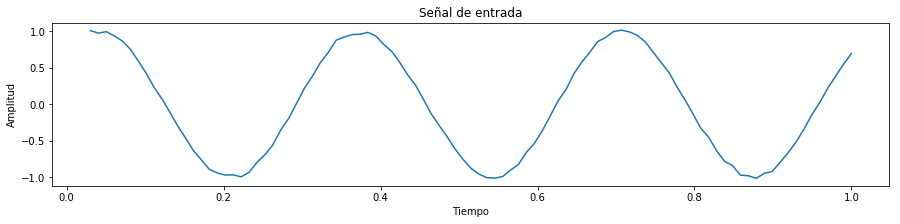

In [8]:
cantidad_graficos = 1
plt.rcParams['figure.figsize'] = [ancho_pantalla, cantidad_graficos*alto_pantalla]

plt.figure()
plt.plot(tiempo[M-1:],senial_entrada[M-1:])
plt.title('Señal de entrada')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
#plt.grid()
plt.show()

### Creo el filtro de Wiever

In [9]:
A_Hermitica                       = Crear_A_Hermitica(senial_entrada,M)
Wiever_coef                      = Wiener_calcular_coeficientes(A_Hermitica,senial_deseada)
senial_estimada                 = A_Hermitica.transpose()@Wiever_coef
ecm = calcular_error_cuadratico_medio(A_Hermitica,senial_deseada)

display('Error cuadrático medio: %f' % (ecm))

'Error cuadrático medio: 0.025937'

### Grafico los resultados

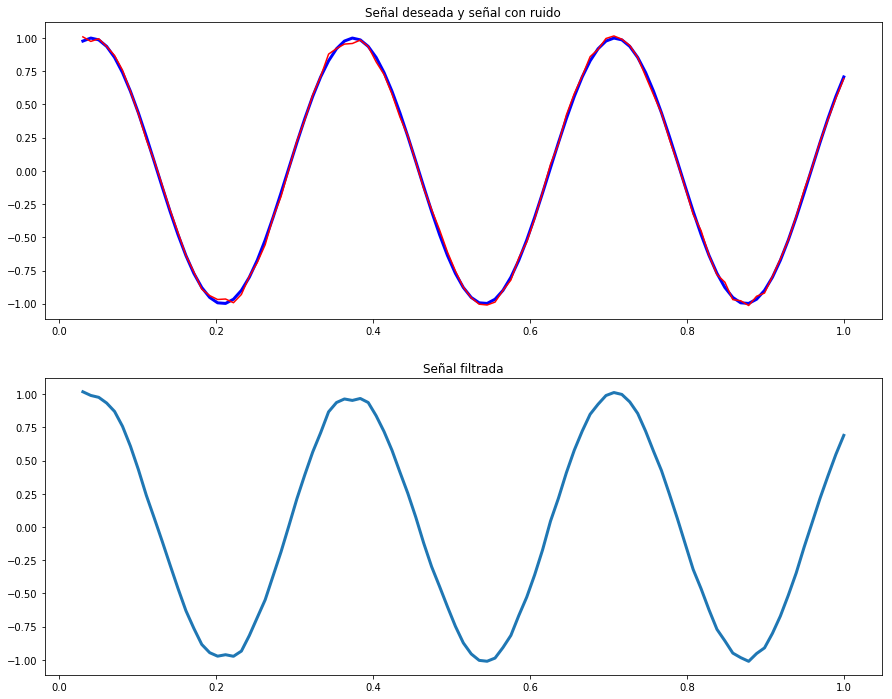

In [10]:
cantidad_graficos = 2
plt.rcParams['figure.figsize'] = [ancho_pantalla, 2*cantidad_graficos*alto_pantalla]

plt.subplot(cantidad_graficos,1,1)
plt.title('Señal deseada y señal con ruido')
plt.plot(tiempo[M-1:],senial[M-1:],'b',linewidth='3')
plt.plot(tiempo[M-1:],senial_entrada[M-1:],'r')
plt.subplot(cantidad_graficos,1,2)
plt.title('Señal filtrada')
plt.plot(t_deseado,senial_estimada,linewidth='3')

## Ahora encapsulo todo lo hecho anteriormente en una sola función (en el primer caso era mejor desmenuzar el problema e ir paso por paso)

In [11]:
def TP_resolver_ejercicio(frec_0,phi_0,frec_muestreo,M,t_max,sigma):
    
    ########################### Configuracion de tiempos ######################################

    N                                 = t_max*frec_muestreo
    tiempo                        = np.linspace(0,t_max,N,endpoint = False)

    ######################### Creacion de la señal a analizar ###################################
    
    senial                         = np.sin(2*frec_0*np.pi*tiempo + phi_0)
    ruido                          =  np.random.normal(0,sigma,np.size(senial))

    senial_entrada           = senial + ruido

    t_deseado                  = tiempo [M-1:]
    senial_deseada          = senial [M-1:]

    ######################## Creacion del filtro de Wiener ####################################

    A_Hermitica                       = Crear_A_Hermitica(senial_entrada,M)
    Wiever_coef                       = Wiener_calcular_coeficientes(A_Hermitica,senial_deseada)
    senial_estimada                 = A_Hermitica.transpose()@Wiever_coef
    ecm = calcular_error_cuadratico_medio(A_Hermitica,senial_deseada)

    display('Error cuadrático medio: %f' % (ecm))

    ########################### Ploteo de los resultados ###################################
    
    ancho_pantalla = 15
    alto_pantalla = 3
    
    cantidad_graficos = 2
    plt.rcParams['figure.figsize'] = [ancho_pantalla, 2*cantidad_graficos*alto_pantalla]

    plt.subplot(cantidad_graficos,1,1)
    plt.title('Señal deseada y señal con ruido')
    plt.plot(tiempo[M-1:],senial[M-1:],'b',linewidth='3')
    plt.plot(tiempo[M-1:],senial_entrada[M-1:],'r')
    plt.subplot(cantidad_graficos,1,2)
    plt.title('Señal filtrada')
    plt.plot(t_deseado,senial_estimada,linewidth='3')
    
    return Wiever_coef

#### Repetimos el primer caso de aplicación para comprobar que se encapsulo correctamente

'Error cuadrático medio: 0.207128'

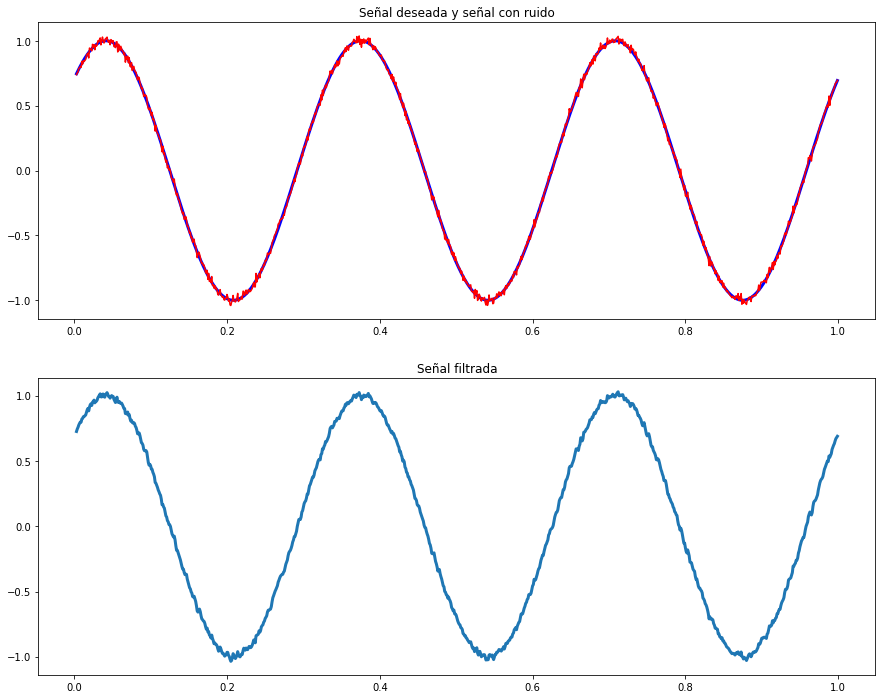

In [12]:
# Configuracion de señal
frec_0                           = 3
phi_0                            = np.pi/4
frec_muestreo              = 1000
M                                  = 4
t_max                           = 1 

# Configuracion de ruido
sigma                          = 0.02

TP_resolver_ejercicio(frec_0,phi_0,frec_muestreo,M,t_max,sigma);


# Ahora podemos analizar otros casos
## Aumento del ruido ($\sigma$ = 0.2)

'Error cuadrático medio: 9.583433'

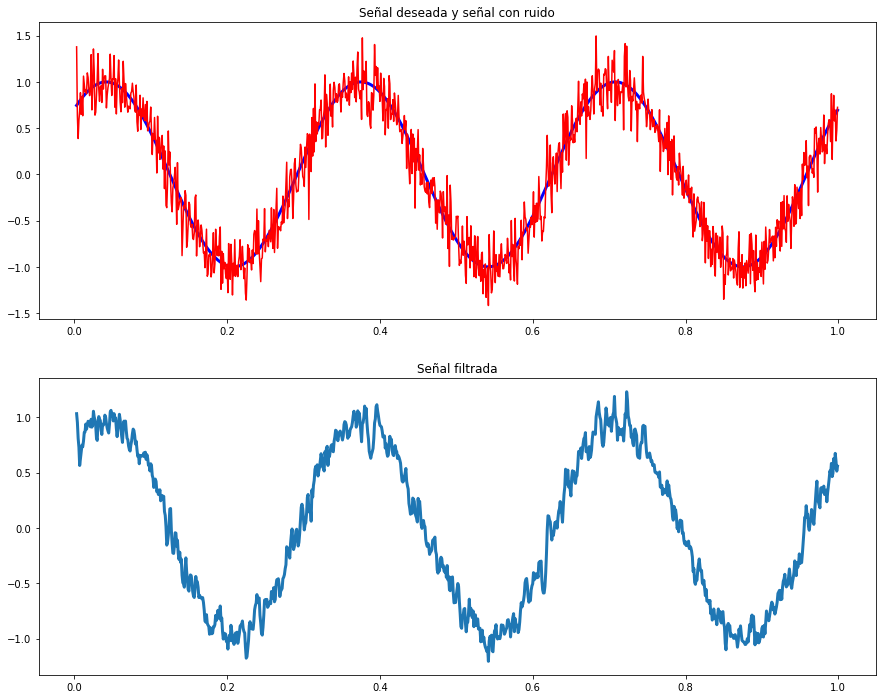

In [13]:
# Configuracion de señal
frec_0                           = 3
phi_0                            = np.pi/4
frec_muestreo              = 1000
M                                  = 4
t_max                           = 1

# Configuracion de ruido
sigma                          = 0.2

TP_resolver_ejercicio(frec_0,phi_0,frec_muestreo,M,t_max,sigma);

Se comprueba que al incrementar $\sigma$ en un orden de magnitud se incrementa el error cuadrático medio en dos ordenes de magnitud

## Aumento del ruido ($\sigma$ = 0.5)

'Error cuadrático medio: 60.528265'

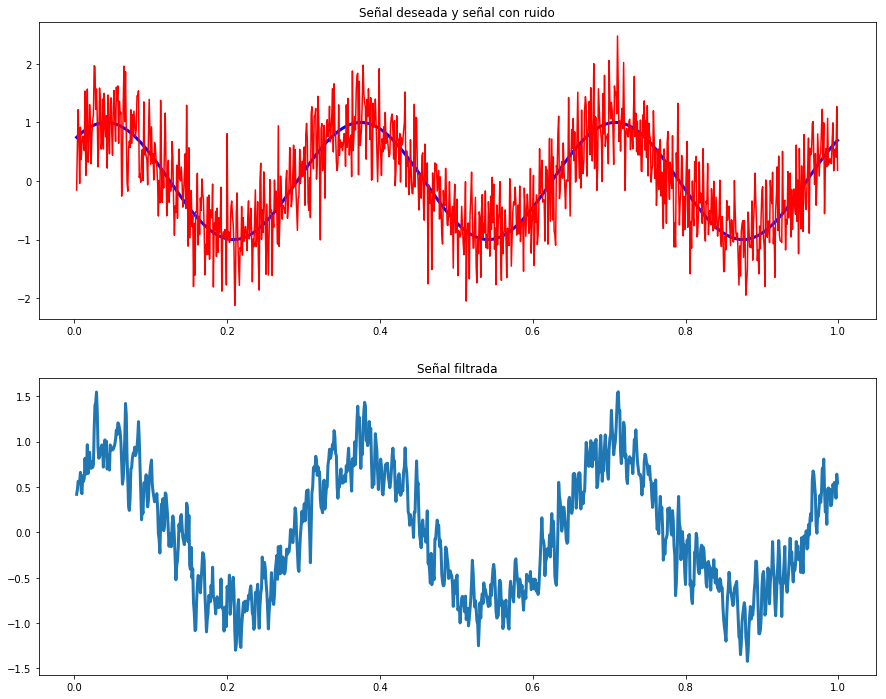

In [14]:
# Configuracion de señal
frec_0                           = 3
phi_0                            = np.pi/4
frec_muestreo              = 1000
M                                  = 4
t_max                           = 1

# Configuracion de ruido
sigma                          = 0.5

TP_resolver_ejercicio(frec_0,phi_0,frec_muestreo,M,t_max,sigma);

Un valor de $\sigma$ tan elevado vuelve a la señal mucho mas dificil de distinguir

## Aumento del ruido ($\sigma$ = 0.75)

'Error cuadrático medio: 110.217306'

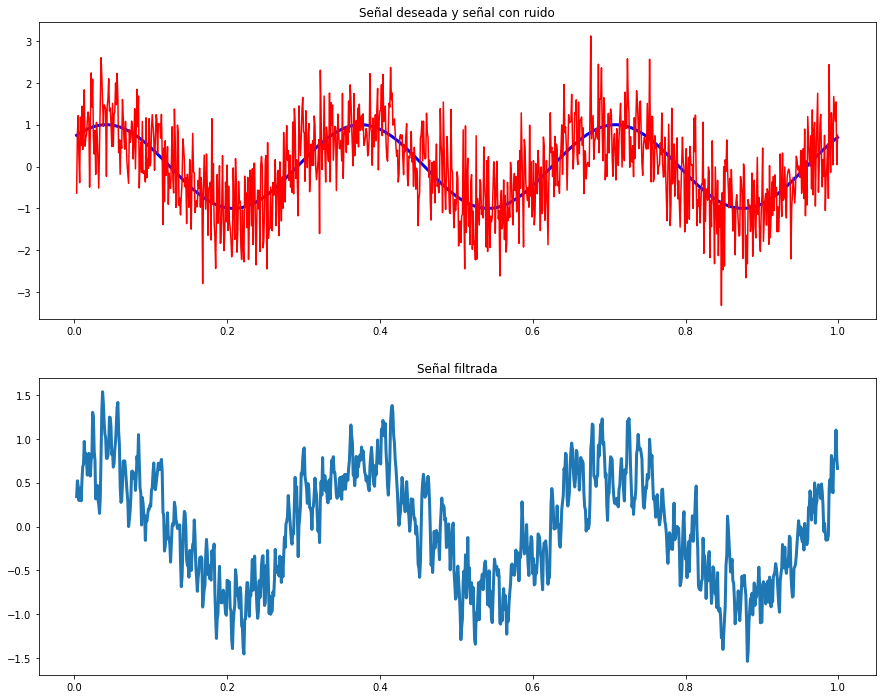

In [15]:
# Configuracion de señal
frec_0                           = 3
phi_0                            = np.pi/4
frec_muestreo              = 1000
M                                  = 4
t_max                           = 1

# Configuracion de ruido
sigma                          = 0.75

TP_resolver_ejercicio(frec_0,phi_0,frec_muestreo,M,t_max,sigma);

Un valor de $\sigma$ cercano a la unidad eleva otro orden de magnitud al error cuadrático medio, aunque aun es posible distinguir los ciclos

## Aumento del ruido ($\sigma$ = 1)

'Error cuadrático medio: 147.230728'

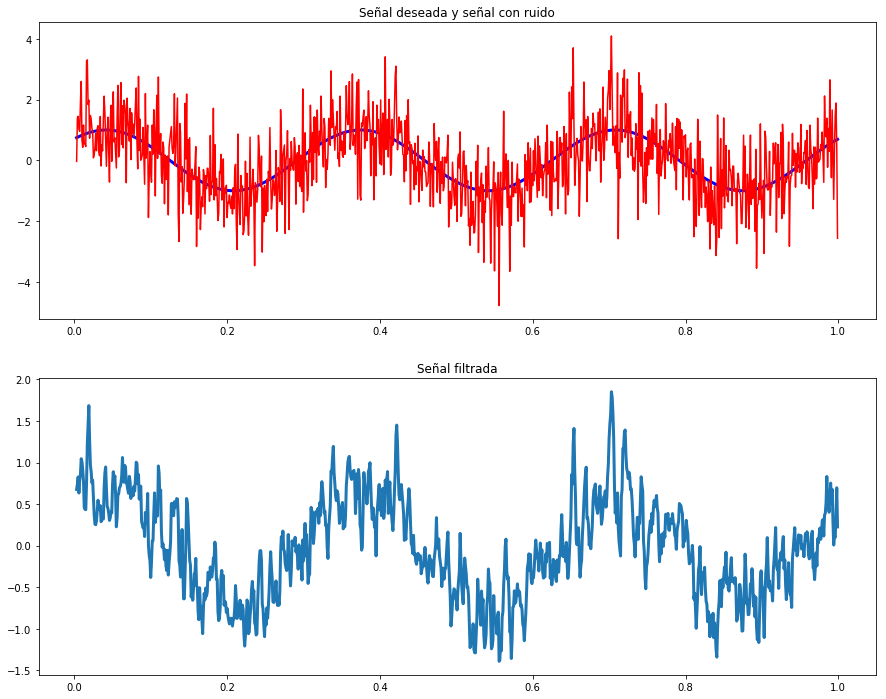

In [16]:
# Configuracion de señal
frec_0                           = 3
phi_0                            = np.pi/4
frec_muestreo              = 1000
M                                  = 4
t_max                           = 1

# Configuracion de ruido
sigma                          = 1

TP_resolver_ejercicio(frec_0,phi_0,frec_muestreo,M,t_max,sigma);

Un valor de $\sigma$ unitario ya entrega partes de la señal que no pueden idetificarse como parte del ciclo positivo o negativo de la senoide

## Aumento del ruido ($\sigma$ = 1) con N = 1000 y M = 100

'Error cuadrático medio: 33.406211'

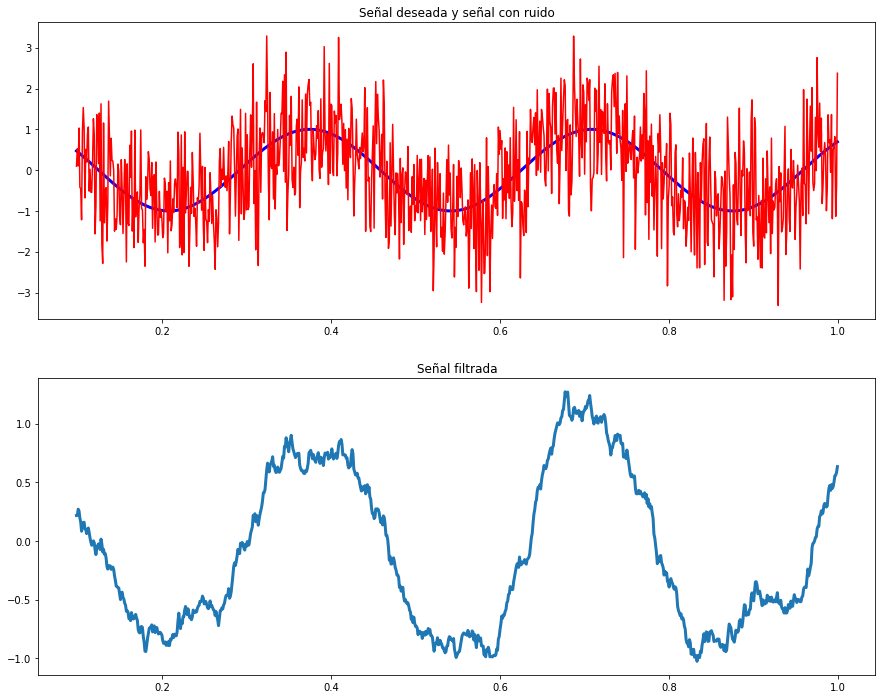

In [17]:
# Configuracion de señal
frec_0                           = 3
phi_0                            = np.pi/4
frec_muestreo              = 1000
M                                  = 100
t_max                           = 1

# Configuracion de ruido
sigma                          = 1

W = TP_resolver_ejercicio(frec_0,phi_0,frec_muestreo,M,t_max,sigma);

Aun cuando $\sigma$ es unitario como en el caso anterior, al tener mas muestras es posible filtrar la señal e identificar cada ciclo de la senoide sin dificultad, a pesar del notable ruido presente.

## Respuesta en frecuencia 

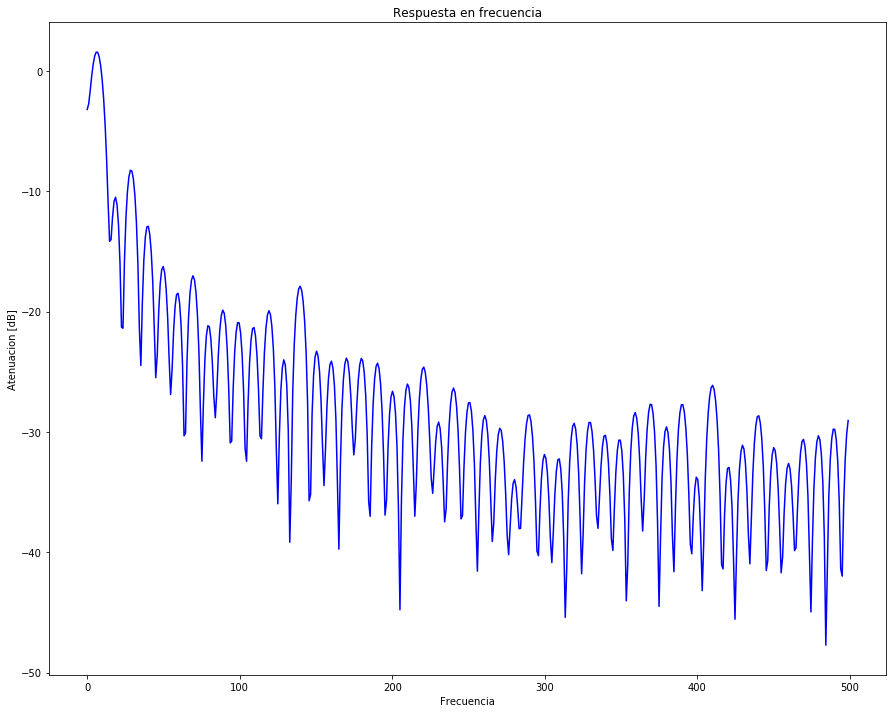

In [18]:
Respuesta_frecuencia_wiener(W,frec_muestreo)

Tenemos claramente un filtro pasa-bajos.

### Con $\sigma=0.5$ y una frecuencia base superior

'Error cuadrático medio: 3.373090'

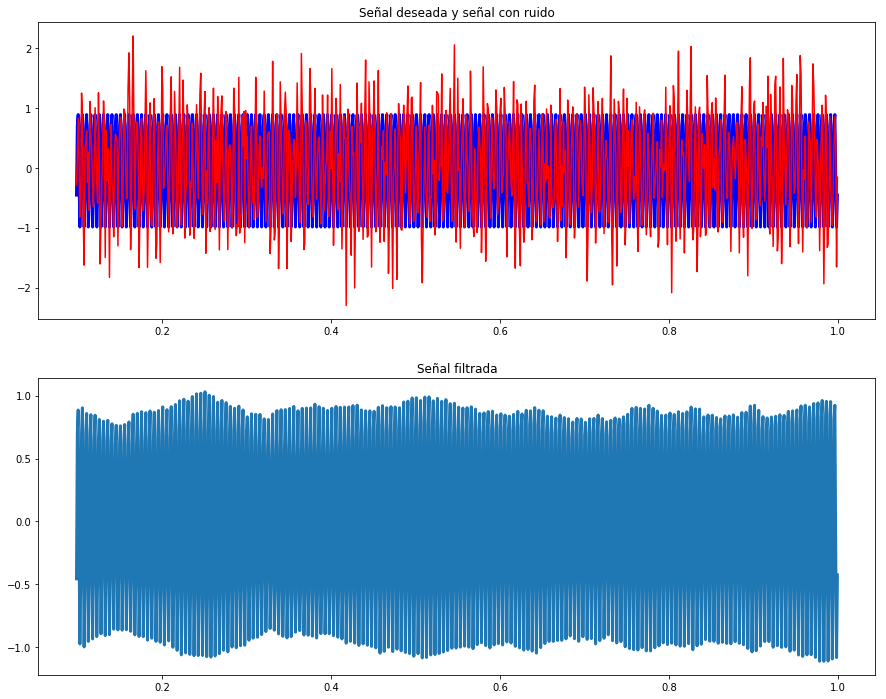

In [19]:
# Configuracion de señal
frec_0                           = 200
phi_0                            = np.pi/4
frec_muestreo              = 1000
M                                  = 100
t_max                           = 1

# Configuracion de ruido
sigma                          = 0.5

W = TP_resolver_ejercicio(frec_0,phi_0,frec_muestreo,M,t_max,sigma);

Para poder apreciar bien la señal filtrada hay que utilizar t_max = 0.05, pero eso complicaría ver la respuesta en frecuencia que es lo importante de este ejemplo, por lo que mantengo t_max = 1.

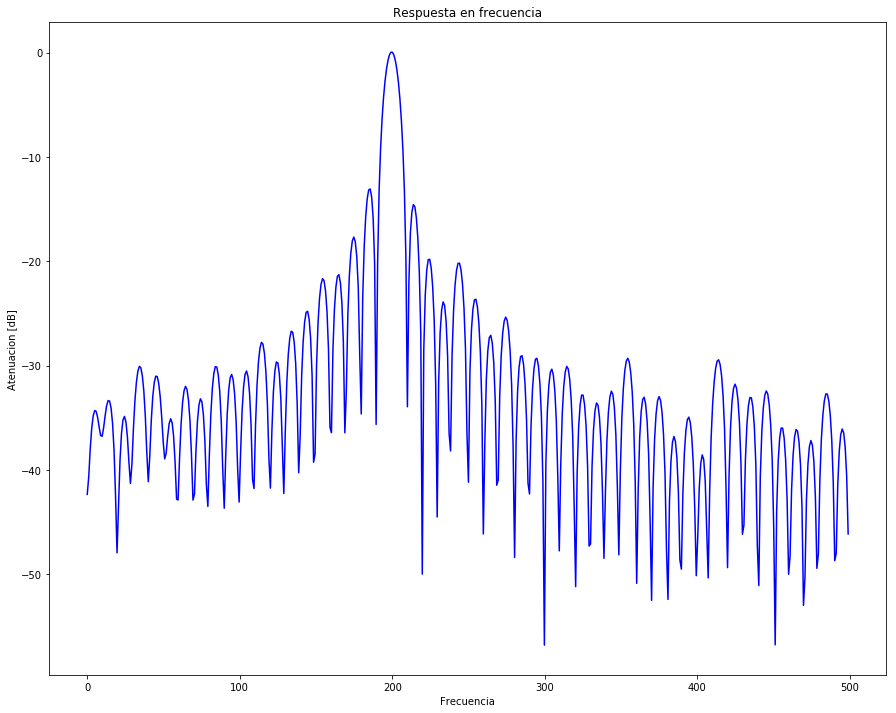

In [20]:
Respuesta_frecuencia_wiener(W,frec_muestreo)

El filtro ha movido su máximo de la respuesta en frecuencia para dejar pasar la frecuencia fundamental de la señal

### Con $\sigma=0.5$ y dos señales superpuestas de diferente frecuencia fundamental

'Error cuadrático medio: 146.165494'

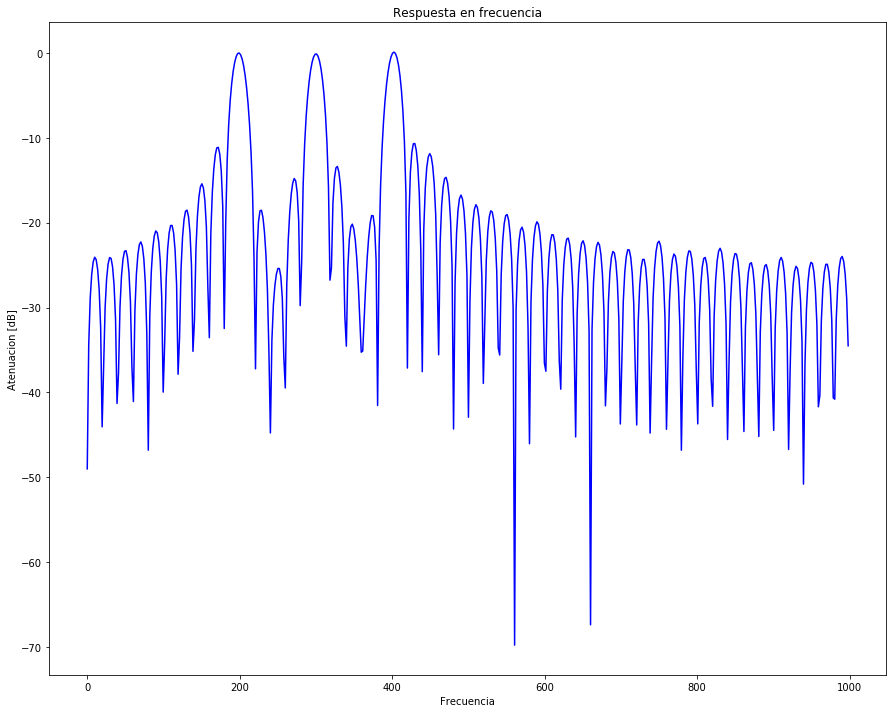

In [21]:
# Configuracion de señal
frec_0                           = 200
frec_1                           = 300
frec_2                           = 400
phi_0                            = np.pi/4
frec_muestreo              = 2000
M                                  = 100
t_max                           = 5

# Configuracion de ruido
sigma                          = 0.5

# Es necesario volver a declarar toda la funcion porque "TP_resolver_ejercicio solo tiene UNA senoide en la señal.

########################### Configuracion de tiempos ######################################

N                                 = t_max*frec_muestreo
tiempo                        = np.linspace(0,t_max,N,endpoint = False)

######################### Creacion de la señal a analizar ###################################

senial                         = np.sin(2*frec_0*np.pi*tiempo + phi_0) + np.sin(2*frec_1*np.pi*tiempo + phi_0) + np.sin(2*frec_2*np.pi*tiempo + phi_0)

ruido                          =  np.random.normal(0,sigma,np.size(senial))

senial_entrada           = senial + ruido

t_deseado                  = tiempo [M-1:]
senial_deseada          = senial [M-1:]

######################## Creacion del filtro de Wiener ####################################

A_Hermitica                       = Crear_A_Hermitica(senial_entrada,M)
Wiever_coef                       = Wiener_calcular_coeficientes(A_Hermitica,senial_deseada)
senial_estimada                 = A_Hermitica.transpose()@Wiever_coef
ecm = calcular_error_cuadratico_medio(A_Hermitica,senial_deseada)

display('Error cuadrático medio: %f' % (ecm))

Respuesta_frecuencia_wiener(Wiever_coef,frec_muestreo)

Es notable como ahora el filtro se volvio selectivo en tres frecuencias, las fundamentales de las senoides incluidas en la señal original.

### Probando con señal cuadrada y $\sigma = 0.5$

'Error cuadrático medio: 49.126783'

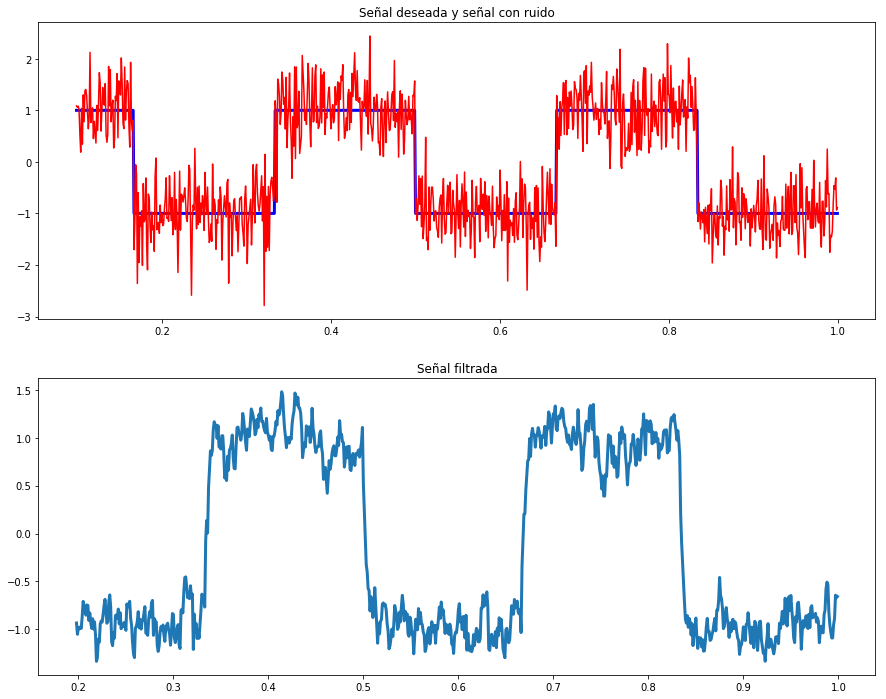

In [22]:
# Configuracion de señal
frec_0                           = 3
phi_0                            = np.pi/4
frec_muestreo              = 1000
M                                  = 100
t_max                           = 1

# Configuracion de ruido
sigma                          = 0.5

# Es necesario volver a declarar toda la funcion porque "TP_resolver_ejercicio solo tiene UNA senoide en la señal.

########################### Configuracion de tiempos ######################################

N                                 = t_max*frec_muestreo
tiempo                        = np.linspace(0,t_max,N,endpoint = False)

######################### Creacion de la señal a analizar ###################################

senial                         = signal.square(2 * np.pi * frec_0 *tiempo)

ruido                          =  np.random.normal(0,sigma,np.size(senial))

senial_entrada           = senial + ruido

t_deseado                  = tiempo [M-1:]
senial_deseada          = senial [M-1:]

######################## Creacion del filtro de Wiener ####################################

A_Hermitica                       = Crear_A_Hermitica(senial_entrada,M)
Wiever_coef                       = Wiener_calcular_coeficientes(A_Hermitica,senial_deseada)
senial_estimada                 = A_Hermitica.transpose()@Wiever_coef
ecm = calcular_error_cuadratico_medio(A_Hermitica,senial_deseada)

display('Error cuadrático medio: %f' % (ecm))

 ########################### Ploteo de los resultados ###################################

ancho_pantalla = 15
alto_pantalla = 3

cantidad_graficos = 2
plt.rcParams['figure.figsize'] = [ancho_pantalla, 2*cantidad_graficos*alto_pantalla]

plt.subplot(cantidad_graficos,1,1)
plt.title('Señal deseada y señal con ruido')
plt.plot(tiempo[M-1:],senial[M-1:],'b',linewidth='3')
plt.plot(tiempo[M-1:],senial_entrada[M-1:],'r')
plt.subplot(cantidad_graficos,1,2)
plt.title('Señal filtrada')
plt.plot(t_deseado[M-1:],senial_estimada[M-1:],linewidth='3')

### Probando con señal cuadrada y $\sigma = 1$

'Error cuadrático medio: 109.489725'

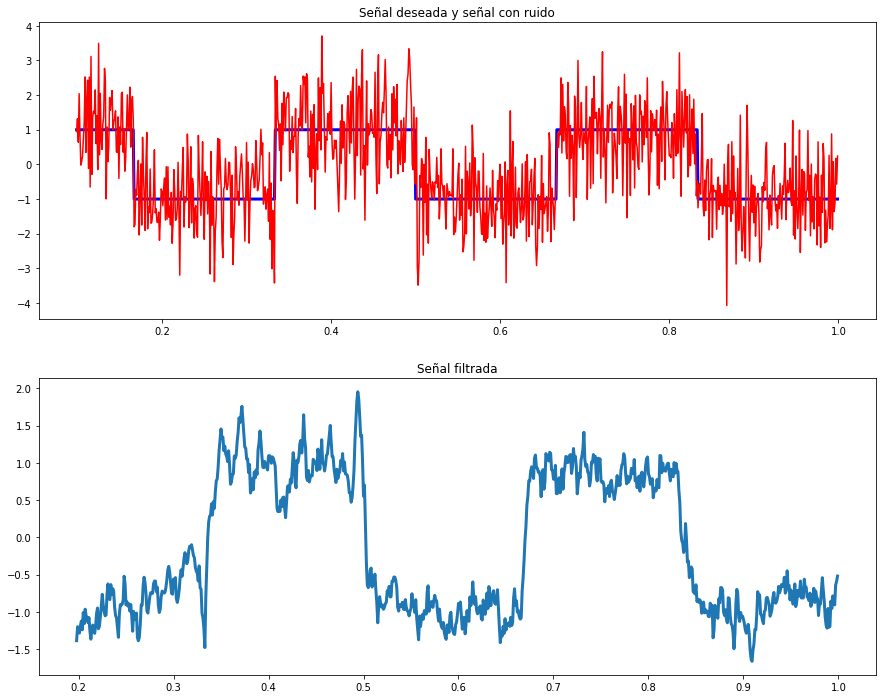

In [23]:
# Configuracion de señal
frec_0                           = 3
phi_0                            = np.pi/4
frec_muestreo              = 1000
M                                  = 100
t_max                           = 1

# Configuracion de ruido
sigma                          = 1

# Es necesario volver a declarar toda la funcion porque "TP_resolver_ejercicio solo tiene UNA senoide en la señal.

########################### Configuracion de tiempos ######################################

N                                 = t_max*frec_muestreo
tiempo                        = np.linspace(0,t_max,N,endpoint = False)

######################### Creacion de la señal a analizar ###################################

senial                         = signal.square(2 * np.pi * frec_0 *tiempo)

ruido                          =  np.random.normal(0,sigma,np.size(senial))

senial_entrada           = senial + ruido

t_deseado                  = tiempo [M-1:]
senial_deseada          = senial [M-1:]

######################## Creacion del filtro de Wiener ####################################

A_Hermitica                       = Crear_A_Hermitica(senial_entrada,M)
Wiever_coef                       = Wiener_calcular_coeficientes(A_Hermitica,senial_deseada)
senial_estimada                 = A_Hermitica.transpose()@Wiever_coef
ecm = calcular_error_cuadratico_medio(A_Hermitica,senial_deseada)

display('Error cuadrático medio: %f' % (ecm))

 ########################### Ploteo de los resultados ###################################

ancho_pantalla = 15
alto_pantalla = 3

cantidad_graficos = 2
plt.rcParams['figure.figsize'] = [ancho_pantalla, 2*cantidad_graficos*alto_pantalla]

plt.subplot(cantidad_graficos,1,1)
plt.title('Señal deseada y señal con ruido')
plt.plot(tiempo[M-1:],senial[M-1:],'b',linewidth='3')
plt.plot(tiempo[M-1:],senial_entrada[M-1:],'r')
plt.subplot(cantidad_graficos,1,2)
plt.title('Señal filtrada')
plt.plot(t_deseado[M-1:],senial_estimada[M-1:],linewidth='3')

En conclusión el predictor ha funcionado correctamente en las siguientes situaciones:
* Señal senoidal con bajo y algo nivel de ruido
* Combinación de senoidales con alto nivel de ruido
* Señal cuadrada con bajo y alto nivel de ruido

En las situaciones de ruido elevado se pudo mejorar la performance (disminuir el error cuadrático medio) al incrementar el valor de M (elementos del filtro), teniendo en mente que no debe superar a N (cantidad de muestras).